In [1]:
using Turing
using LimberJack
using LinearAlgebra
using CSV
using NPZ
using Plots
using FITSIO
using ForwardDiff
using BenchmarkTools
using DelimitedFiles

┌ Info: Precompiling LimberJack [6b86205d-155a-4b14-b82d-b6a149ea78f2]
└ @ Base loading.jl:1423


In [2]:
files = npzread("../data/DESY1_cls/Cls_meta.npz")
Cls_meta = cls_meta(files)

cls_meta{Vector{Vector{Int64}}}([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3]], [[1, 0, 1, 0], [1, 1, 1, 1], [1, 2, 1, 2], [1, 3, 1, 3], [1, 4, 1, 4], [1, 0, 2, 0], [1, 0, 2, 1], [1, 0, 2, 2], [1, 0, 2, 3], [1, 1, 2, 0]  …  [2, 0, 2, 0], [2, 0, 2, 1], [2, 0, 2, 2], [2, 0, 2, 3], [2, 1, 2, 1], [2, 1, 2, 2], [2, 1, 2, 3], [2, 2, 2, 2], [2, 2, 2, 3], [2, 3, 2, 3]], [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 6]  …  [6, 6], [6, 7], [6, 8], [6, 9], [7, 7], [7, 8], [7, 9], [8, 8], [8, 9], [9, 9]])

In [3]:
cov_tot = files["cov"]
inv_cov_tot = files["inv_cov"]
data_vector = files["cls"];

In [4]:
#                Omega_b,           Omega_c          n_s,                 h,
#                DESgc__0_gc_b,     DESgc__1_gc_b,   DESgc__2_gc_b,    DESgc__3_gc_b,    DESgc__4_gc_b,
#                DESgc__0_dz,      DESgc__1_dz,      DESgc__2_dz,      DESgc__3_dz,      DESgc__4_dz,
#                wl_ia_A,          wl_ia_eta, 
#                DESwl__0_wl_m,    DESwl__1_wl_m,    DESwl__2_wl_m,    DESwl__3_wl_m,
#                DESwl__0_dz,      DESwl__1_dz,      DESwl__2_dz,      DESwl__3_dz,
#                sigma_8,          Omega_m
carlos_params1 = [4.426868e-02,     2.093138e-01,     8.963611e-01,     8.495440e-01,
                 1.343888e+00,    1.639047e+00,      1.597174e+00,     1.944583e+00,     2.007245e+00,
                -4.679383e-03,   -2.839996e-03,      1.771571e-03,     1.197051e-03,    -5.199799e-03,
                 2.389208e-01,   -6.435288e-01, 
                 1.802722e-03,   -5.508994e-03,     1.952514e-02,    -1.117726e-03,
                -1.744083e-02,    6.777779e-03,    -1.097939e-03,    -4.912315e-03,
                 8.536883e-01,    2.535825e-01];

In [5]:
cls_carlos = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info.npz");
cls_carlos2 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp.npz");
cls_carlos3 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp_EH.npz");
cls_carlos4 = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info_nointerp_EH_noconv.npz");

In [6]:
pars = carlos_params1
nuisances = Dict("b0" => pars[5],
                 "b1" => pars[6],
                 "b2" => pars[7],
                 "b3" => pars[8],
                 "b4" => pars[9],
                 "dz_g0" => pars[10],
                 "dz_g1" => pars[11],
                 "dz_g2" => pars[12],
                 "dz_g3" => pars[13],
                 "dz_g4" => pars[14],
                 "dz_k0" => pars[21],
                 "dz_k1" => pars[22],
                 "dz_k2" => pars[23],
                 "dz_k3" => pars[24],
                 "m0" => pars[17],
                 "m1" => pars[18],
                 "m2" => pars[19],
                 "m3" => pars[20],
                 "A_IA" => pars[15],
                 "alpha_IA" => pars[16]);

In [7]:
function make_cls(pars)
    nuisances = Dict("b0" => pars[5],
                     "b1" => pars[6],
                     "b2" => pars[7],
                     "b3" => pars[8],
                     "b4" => pars[9],
                     "dz_g0" => pars[10],
                     "dz_g1" => pars[11],
                     "dz_g2" => pars[12],
                     "dz_g3" => pars[13],
                     "dz_g4" => pars[14],
                     "dz_k0" => pars[21],
                     "dz_k1" => pars[22],
                     "dz_k2" => pars[23],
                     "dz_k3" => pars[24],
                     "m0" => pars[17],
                     "m1" => pars[18],
                     "m2" => pars[19],
                     "m3" => pars[20],
                     "A_IA" => pars[15],
                     "alpha_IA" => pars[16])

    Ωm = pars[26]
    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]
    s8 = pars[25]
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, 
                                     tk_mode="EisHu", Pk_mode="Halofit", nz="250") #, 
                                     #nk=500, nz=500, nz_pk=500)

    return Theory(cosmology, nuisances, Cls_meta, files)

end

make_cls (generic function with 1 method)

In [10]:
function diff_cls_nuisance(dz_g0)
    nuisance = Dict("dz_g0"=> dz_g0)
    cosmology = LimberJack.Cosmology(0.3, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    cls = Theory(cosmology, nuisances, Cls_meta, files)
    return cls
end

function diff_cls(Ωm)
    cosmology = LimberJack.Cosmology(Ωm, 0.05, 0.67, 0.96, 0.81, tk_mode="EisHu", Pk_mode="Halofit")
    cls = Theory(cosmology, nuisances, Cls_meta, files)
    return cls
end


diff_cls (generic function with 1 method)

In [11]:
ForwardDiff.derivative(diff_cls_nuisance, 0.01)
#@time [ForwardDiff.derivative(diff_cls_linear, 0.30) for i in 1:10]

475-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [12]:
ForwardDiff.derivative(diff_cls, 0.30)
#@time [ForwardDiff.derivative(diff_cls_linear, 0.30) for i in 1:10]

475-element Vector{Float64}:
 -0.0010205084356980057
 -0.00016234710766388838
 -1.5527370319049503e-5
 -9.386182420868606e-7
  1.4963999860269987e-6
 -0.0006747855760049715
 -0.00015734965529657754
 -7.788724567349436e-5
 -1.5077014538223157e-5
 -9.018854160875104e-6
  1.1357961077604898e-6
  1.2973069950605295e-6
  1.9486970299581516e-6
  ⋮
  3.92859469854495e-9
  3.3938613502302558e-9
  2.9397093145866578e-9
  2.54820488924275e-9
  2.204685928961294e-9
  1.9083408624592226e-9
  1.6470174476664335e-9
  1.4150581037525424e-9
  1.2109170082901289e-9
  1.031180624176585e-9
  8.724220176475103e-10
  7.326457677444748e-10

In [13]:
cls_jaime1 = make_cls(carlos_params1);

In [14]:
open("jaime_cls.txt", "w") do io
       writedlm(io, cls_jaime1)
end

In [15]:
compa1 = @. abs(cls_carlos["cls"]-cls_jaime1)/cls_carlos["cls"];
compa2 = @. abs(cls_carlos2["cls"]-cls_jaime1)/cls_carlos2["cls"];
compa3 = @. abs(cls_carlos3["cls"]-cls_jaime1)/cls_carlos3["cls"];
compa4 = @. abs(cls_carlos4["cls"]-cls_jaime1)/cls_carlos4["cls"];

println("Mean discrepancy default   ", mean(compa1))
println("Mean discrepancy no itp    ", mean(compa2))
println("Mean discrepancy no itp+EH ", mean(compa3))
println("Mean discrepancy no itp+EH+noconv ", mean(compa4))

Mean discrepancy default   0.02624317709180139
Mean discrepancy no itp    0.019281569521549392
Mean discrepancy no itp+EH 0.01513310991881758
Mean discrepancy no itp+EH+noconv 0.011126357021471647


In [16]:
chi2_carlos = cls_carlos["chi2_nolp"]
chi2_carlos2 = cls_carlos2["chi2_nolp"]
chi2_carlos3 = cls_carlos3["chi2_nolp"]
chi2_carlos4 = cls_carlos4["chi2_nolp"]
println(chi2_carlos)
println(chi2_carlos2)
println(chi2_carlos3)
println(chi2_carlos4)

495.62231927779936
495.00947244084654
495.89420547809317
497.2051355000593


In [17]:
chi2_jaime1 = dot((cls_jaime1 .- data_vector), inv_cov_tot  * (cls_jaime1 .- data_vector))
println(chi2_jaime1)

497.43273905551644


In [23]:
(chi2_jaime1-chi2_carlos4)/chi2_carlos4

-0.0006365091598775208

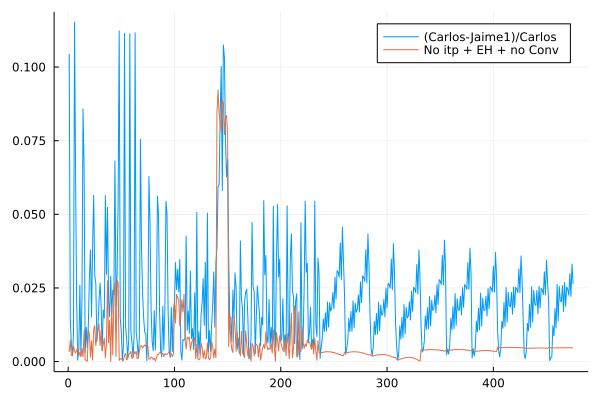

In [24]:
plot(compa1, label="(Carlos-Jaime1)/Carlos")
plot!(compa4, label="No itp + EH + no Conv")

In [14]:
@model function model(data_vector::Vector{Float64})
    Ωm ~ Uniform(0.1, 0.6)
    Ωb ~ Uniform(0.03, 0.07)
    h ~ Uniform(0.6, 0.9)
    s8 ~ Uniform(0.6, 1.0)
    ns ~ Uniform(0.87, 1.07)
    
    b0 ~ Uniform(0.8, 3.0)
    b1 ~ Uniform(0.8, 3.0)
    b2 ~ Uniform(0.8, 3.0)
    b3 ~ Uniform(0.8, 3.0)
    b4 ~ Uniform(0.8, 3.0)
    
    #dz_g0 ~ Normal(0.008, 0.007)
    #dz_g1 ~ Normal(-0.005, 0.007)
    #dz_g2 ~ Normal(0.006, 0.006)
    #dz_g3 ~ Normal(0.0, 0.010)
    #dz_g4 ~ Normal(0.0, 0.010)
    
    #dz_k0 ~ Normal(-0.001, 0.016)
    #dz_k1 ~ Normal(-0.019, 0.013)
    #dz_k2 ~ Normal(-0.009, 0.011)
    #dz_k3 ~ Normal(-0.018, 0.022)
    
    m0 ~ Normal(0.0, 0.035)
    m1 ~ Normal(0.0, 0.035)
    m2 ~ Normal(0.0, 0.035)
    m3 ~ Normal(0.0, 0.035)
    
    A_IA ~ Uniform(-5, 5) 
    alpha_IA ~ Uniform(-5, 5)

    nuisances = Dict("b0" => b0,
                     "b1" => b1,
                     "b2" => b2,
                     "b3" => b3,
                     "b4" => b4,
                     #"dz_g0" => dz_g0,
                     #"dz_g1" => dz_g1,
                     #"dz_g2" => dz_g2,
                     #"dz_g3" => dz_g3,
                     #"dz_g4" => dz_g4,
                     #"dz_k0" => dz_k0,
                     #"dz_k1" => dz_k1,
                     #"dz_k2" => dz_k2,
                     #"dz_k3" => dz_k3,
                     "m0" => m0,
                     "m1" => m1,
                     "m2" => m2,
                     "m3" => m3,
                     "A_IA" => A_IA,
                     "alpha_IA" => alpha_IA)
    cosmology = LimberJack.Cosmology(Ωm, 0.05, 0.67, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = Theory(cosmology, nuisances, Cls_meta, files)
    data_vector ~ MvNormal(theory, cov_tot)
    return data_vector
end;

In [23]:
iterations = 300
nadapts = 100;

In [24]:
chain1 = sample(model(data_vector), MH(), iterations,
            nadapt=nadapts, progress=true; save_state=true);

LoadError: InterruptException:

In [ ]:
chain3 = sample(model(data_vector), NUTS(5, 0.1), iterations,
                progress=true; save_state=true);

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/jaime/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:   1%|▌                                        |  ETA: 0:59:57┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)

In [ ]:
iterations = 1000
adaptation = 100
TAP = 0.6

NUTS_chain = sample(model(data_vector), NUTS(adaptation, TAP),
            iterations, progress=true; save_state=true);

In [ ]:
describe(NUTS_chain)[1]

In [ ]:
plot(NUTS_chain)